In [263]:
import cmocean
import numpy as np
import xarray as xr
from scipy import signal
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from thermal.derived_fields import calc_mean_enthalpy
from thermal.plotting import enthalpy_pcolormesh, make_colorbar

plt.rcParams['text.usetex'] = True

def get_ELA_indexes(src): 
    # function to find the indexes of the ELA, as a function of time 
    # Generalized enough to support multiple horizontal indexes being at the ELA
        
    # create a two dimensional 'coord_1' array for boolean masking
    _, coord_1 = xr.broadcast(src.t, src.coord_1)
    
    # the difference of the sign will tell us where the mass balance crosses zero
    mask = xr.apply_ufunc(np.diff, 
                          np.sign(src['mass balance']), 
                          kwargs={"axis": -1, "prepend" : -1},
                          dask="allowed")

    # the difference should be 2 at the ELA, 0 all other places
    ELA_idxs = coord_1.where(mask == 2, drop=True)
    
    # probably need to rename the coordinate. 
    return ELA_idxs


def height_at_ELA(ds, ELA_idxs):
    """ ds -> ice thickness along free surface
    """
    
    # get the indexes as numpy interger array, squeeze the time dimension
    idxs = ELA_idxs.sel(t=ds.t).dropna('ELA_coords').astype(int).squeeze().values
    
    if idxs.size > 1: 
        # if multiple gridcells @ ELA; take the mean
        return ds.sel(coord_1=idxs).mean('coord_1')
    else: 
        # otherwise return single ice-thickness
        return ds.sel(coord_1=idxs)
    

In [92]:
drive_src = '/Volumes/thermal/Thesis/thermal-structure/expr/03_PeriodicSurge/'
zarr_path = 'result/crmpt12/gridded/crmpt12_dx_50_TT_3000.0_MB_-0.37_OFF_Tma_-8.5_B_{beta:1.3e}_SP_2_QP_{QP}.zarr'

src_fp = drive_src + zarr_path

In [233]:
_, norm, s_map, bounds = make_colorbar(-np.log(np.logspace(-6, -8, 9)), cmap='magma')
#overwrite the colormap wiht a cmocean colormap
cmap = cmocean.cm.thermal

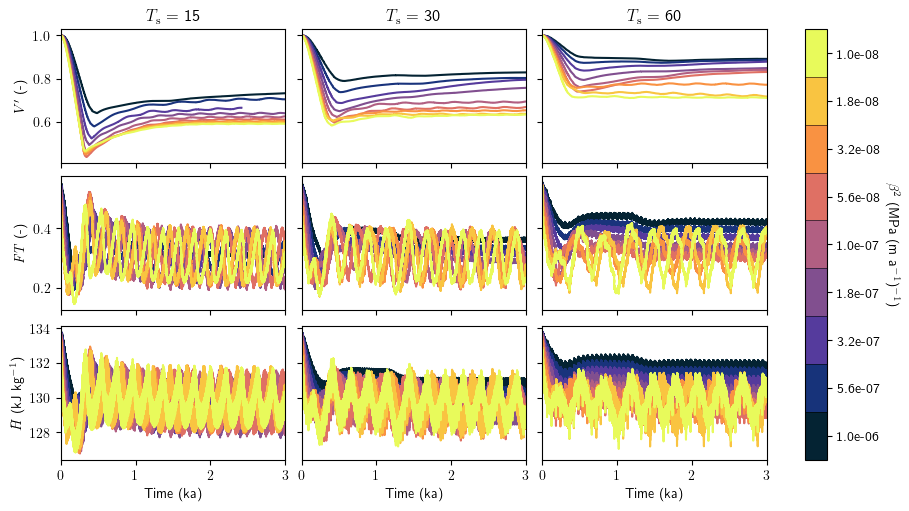

In [259]:
fig, ax = plt.subplots(3,3, sharex=True, sharey='row', 
                       figsize=(9,5), constrained_layout=True)

for i, QP in enumerate([13, 28, 58]): 
    for beta in np.logspace(-6, -8, 9)**0.5: 
            
        color = cmap(norm(-np.log(beta**2)))
        
        src = xr.open_zarr(src_fp.format(beta=beta, QP=QP))

        ax[0,i].plot(src.t/1e3, src.relative_volume, color=color)
        ax[1,i].plot(src.t/1e3, src.percent_temperate/100, color=color)
        ax[2,i].plot(src.t/1e3, calc_mean_enthalpy(src)/1e3, color=color)
    
    ax[0,i].set_title(r'$T_{\rm s}$ = ' + str(QP+2))
    ax[2,i].set_xlabel('Time (ka)')

ax[0,0].set_xlim(0,3);
ax[0,0].set_ylabel("$V'$ (-)");
ax[1,0].set_ylabel(r"$\mathit{FT}$ (-)");
ax[2,0].set_ylabel(r"$\bar{H}$ (kJ kg$^{-1}$)");

s_map = cm.ScalarMappable(norm=norm, cmap=cmap,)
s_map.set_array(-np.log(np.logspace(-6, -8, 9)))
    
cbar = fig.colorbar(s_map, 
                    ax=ax, 
                    norm=norm, 
                    spacing='proportional',
                    ticks=-np.log(np.logspace(-6, -8, 9)), 
                    boundaries=bounds,
                    drawedges=True,
                    )
    
cbar.set_ticklabels(map(lambda x: f'{x:1.1e}', np.logspace(-6, -8, 9)))

cbar.set_label(r"$\beta^2$ (MPa (m a$^{-1}$)$^{-1}$)", rotation=270, labelpad=15)

fig.savefig('/Users/andrewnolan/Desktop/new_periodic_results.png', dpi=400)

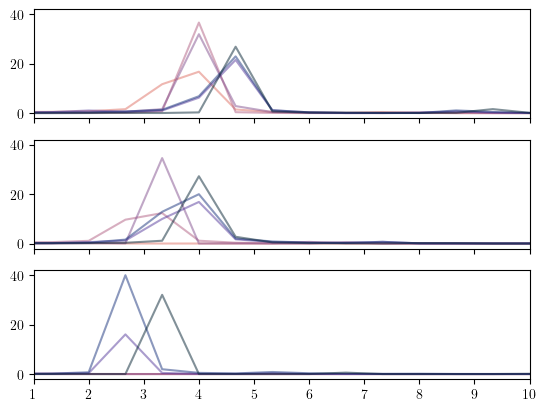

In [203]:
fig, ax = plt.subplots(3,1, sharex=True, sharey=True)

for i, QP in enumerate([13, 28, 58]): 
    for beta in np.logspace(-6, -8, 9)[3:]**0.5: 
            
        color = cmap(norm(beta**2))
        
        src = xr.open_zarr(src_fp.format(beta=beta, QP=QP))
        
        # resample the time axis to a constant spacing 
        FT = src.percent_temperate.interp(t=np.linspace(0.1,3e3, 30_000),
                                          method="linear",
                                          kwargs={"fill_value": "extrapolate"},)
        
        # compute the periodogram
        f, Pxx = signal.periodogram(FT.isel(t=slice(15000,None)), 
                                    1000 / 0.1, scaling='spectrum')
        
        # plot
        ax[i].plot(f, Pxx, c=color, alpha=0.5)
        
    # ax[i].set_yscale('log')
    # ax[i].set_xscale('log')

# ax.set_ylim(1e-1, None)

    ax[i].set_xlim(1, 10)

In [277]:
(1e-7)**0.5

0.00031622776601683794

In [283]:
src = xr.open_zarr(src_fp.format(beta=(1e-7)**0.5, QP=13))

In [284]:
ELA_idxs = get_ELA_indexes(src).compute()
ELA_idxs = ELA_idxs.rename({'coord_1' : 'ELA_coords'})

In [285]:
# load the dask array into memory
# Only a couple MBs so dask will just slow us down
subset = src.height.isel(coord_2=-1).load()

# ELA_idxs has to be explicity passed
ELA_H  = subset.groupby('t').map(height_at_ELA, ELA_idxs=ELA_idxs)

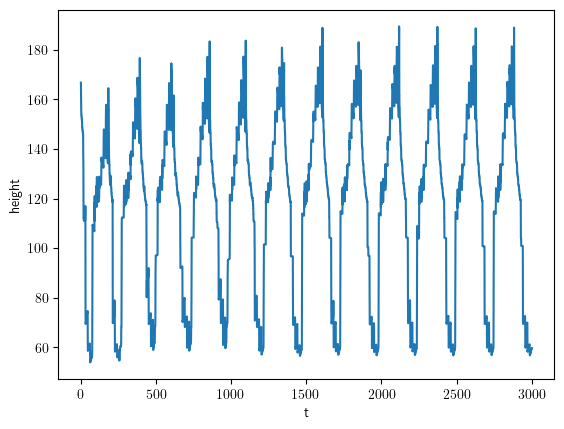

In [286]:
ELA_H.plot()

In [300]:
src.interp(t=np.linspace(0.1,3e3, 30_000))

<xarray.Dataset>
Dimensions:                (t: 30000, coord_2: 16, coord_1: 222)
Coordinates:
  * t                      (t) float64 0.1 0.2 0.3 0.4 ... 3e+03 3e+03 3e+03
Dimensions without coordinates: coord_2, coord_1
Data variables: (12/26)
    SR_xx                  (t, coord_2, coord_1) float64 dask.array<chunksize=(30000, 16, 222), meta=np.ndarray>
    SR_xz                  (t, coord_2, coord_1) float64 dask.array<chunksize=(30000, 16, 222), meta=np.ndarray>
    SR_zz                  (t, coord_2, coord_1) float64 dask.array<chunksize=(30000, 16, 222), meta=np.ndarray>
    X                      (coord_2, coord_1) float64 dask.array<chunksize=(16, 222), meta=np.ndarray>
    Z                      (t, coord_2, coord_1) float64 dask.array<chunksize=(30000, 16, 222), meta=np.ndarray>
    densi                  (t, coord_2, coord_1) float64 dask.array<chunksize=(30000, 16, 222), meta=np.ndarray>
    ...                     ...
    temperature            (t, coord_2, coord_1) float64 dask.array<chunksize=(30000, 16, 222), meta=np.ndarray>
    vel_m                  (t, coord_2, coord_1) float64 dask.array<chunksize=(30000, 16, 222), meta=np.ndarray>
    vel_x                  (t, coord_2, coord_1) float64 dask.array<chunksize=(30000, 16, 222), meta=np.ndarray>
    vel_z                  (t, coord_2, coord_1) float64 dask.array<chunksize=(30000, 16, 222), meta=np.ndarray>
    w                      (t, coord_2, coord_1) float64 dask.array<chunksize=(30000, 16, 222), meta=np.ndarray>
    water content          (t, coord_2, coord_1) float64 dask.array<chunksize=(30000, 16, 222), meta=np.ndarray>

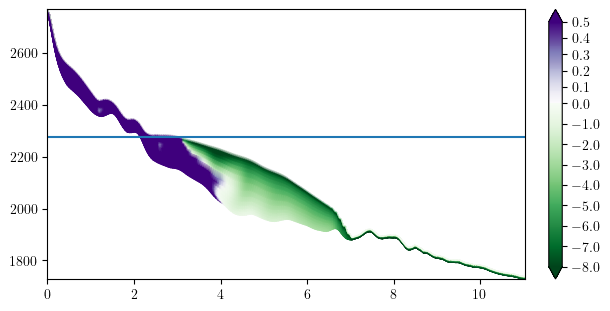

In [301]:
src = xr.open_zarr(src_fp.format(beta=1e-4, QP=28))

    
fig, ax, cbar = enthalpy_pcolormesh(src, -975)

ax.axhline(2275)


# ax2 = ax.twinx()
# ax2.plot(src.X[0,::-1]/1e3, src['mass balance'].isel(t=-1))
# ax2.plot(src.X[0,::-1]/1e3, src.q_lat.isel(t=-10).sum('coord_2'))

In [333]:
(16 - 1) * (222 - 1)

3315

In [329]:
from thermal.elements import calc_element_area

calc_element_area(src).element.size

3315

In [325]:
# src_fp = '/Volumes/thermal/Thesis/thermal-structure/expr/00_CoupledInit/result/crmpt12/nc/'
src_fp = '../../00_CoupledInit/result/crmpt12/nc/'
xr.open_dataset(src_fp + 'crmpt12_dx_50_NT_500_dt_1.0_MB_-0.5_OFF_Tma_-8.0_prog.nc')

<xarray.Dataset>
Dimensions:                (nMesh_face: 3315, nMaxMesh_face_nodes: 4,
                            nMesh_node: 3552, time: 500)
Coordinates:
  * time                   (time) float64 1.0 2.0 3.0 4.0 ... 498.0 499.0 500.0
Dimensions without coordinates: nMesh_face, nMaxMesh_face_nodes, nMesh_node
Data variables: (12/21)
    Mesh                   int32 ...
    Mesh_face_nodes        (nMesh_face, nMaxMesh_face_nodes) float64 ...
    Mesh_node_x            (nMesh_node) float64 ...
    Mesh_node_y            (time, nMesh_node) float64 ...
    BulkElement_Area       (nMesh_face) float64 ...
    pressure               (time, nMesh_node) float64 ...
    ...                     ...
    zs                     (time, nMesh_node) float64 ...
    zbed                   (time, nMesh_node) float64 ...
    mass balance           (time, nMesh_node) float64 ...
    depth                  (time, nMesh_node) float64 ...
    height                 (time, nMesh_node) float64 ...
    densi                  (time, nMesh_node) float64 ...

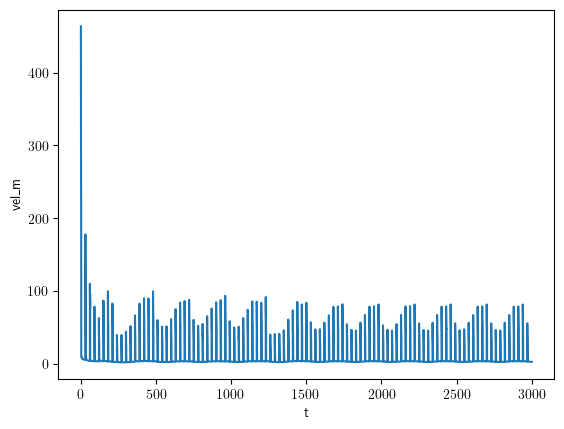

In [91]:
src.vel_m.isel(coord_2=-1).mean('coord_1').plot()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


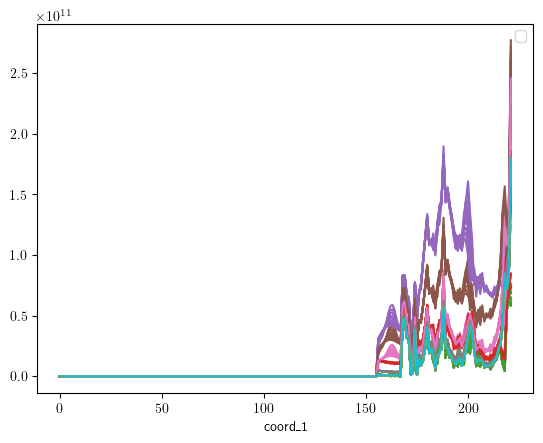

In [39]:
(src.q_lat * src.densi).sum('coord_2').isel(t=slice(-100,None)).plot(x='coord_1', hue='t', label=None);

plt.legend()

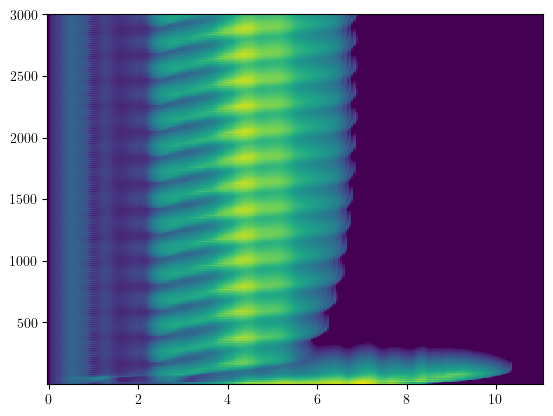

In [60]:
plt.pcolormesh(src.X[0,::-1]/1e3, src.t, src['height'].isel(coord_2=-1))#, cmap='RdBu', vmin=-2.0, vmax=2.0)

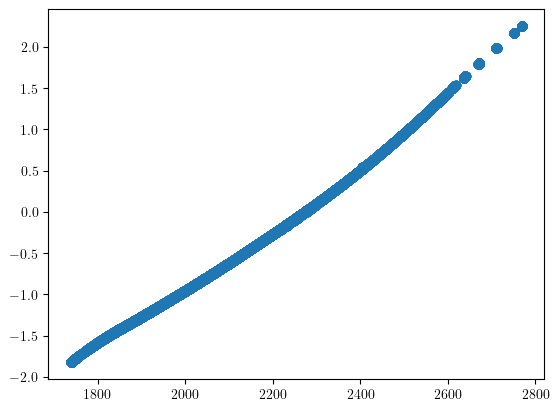

In [63]:
plt.scatter(src.Z.isel(coord_2=-1), src['mass balance'])

In [61]:
dHdt = src['height'].isel(coord_2=-1).interp(t=np.linspace(0,3e3, 3000))
dHdt = dHdt.differentiate('t')

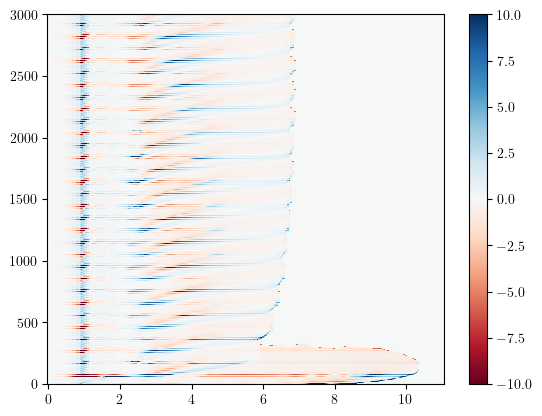

In [62]:
plt.pcolormesh(src.X[0,::-1]/1e3, dHdt.t, dHdt, cmap='RdBu', vmin=-10.0, vmax=10.0)

# plt.ylim(2750, 3000)
plt.colorbar()

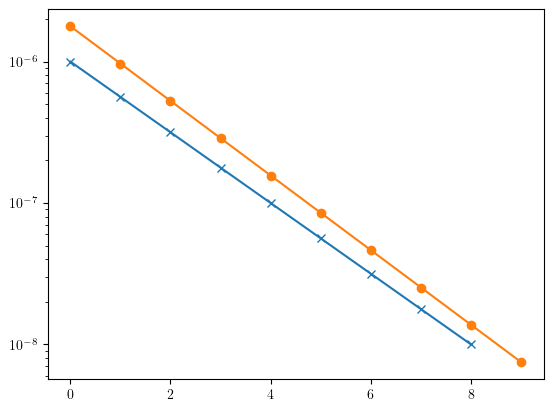

In [94]:
plt.plot(np.logspace(-6, -8, 9), marker='x')
plt.plot(np.logspace(-6 + 0.25, -8-0.125, 10), marker='o')
plt.yscale('log')

In [230]:
src['height'].isel(coord_2=-1).interp(t=np.linspace(0,3e3, 60000))

<xarray.DataArray 'height' (t: 60000, coord_1: 222)>
dask.array<transpose, shape=(60000, 222), dtype=float64, chunksize=(60000, 222), chunktype=numpy.ndarray>
Coordinates:
  * t        (t) float64 0.0 0.05 0.1 0.15 0.2 ... 3e+03 3e+03 3e+03 3e+03 3e+03
Dimensions without coordinates: coord_1

In [145]:
from thermal.open import dataset as open_dataset

In [156]:
src = open_dataset('../../02_surge2steady/result/crmpt12/nc/crmpt12_dx_50_NT_40_dt_0.05_MB_-0.37_OFF_Tma_-8.5_B_1.000e-04_pseudo.nc')

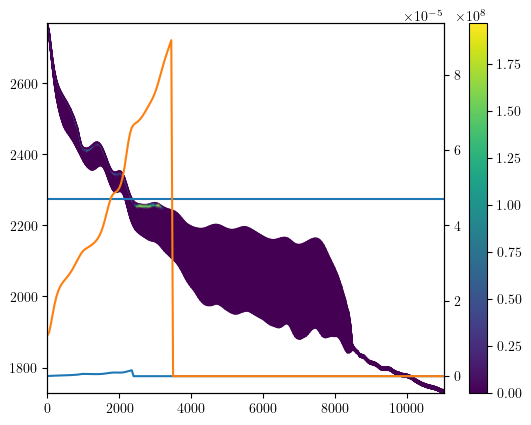

In [159]:
fig, ax = plt.subplots()

im = ax.pcolormesh(src['X'][:,::-1], 
                   src['Z'].isel(t=-1), 
                   src.q_lat.isel(t=-1),
                   # vmax=0.5,
                   shading='gouraud')

ax2 = ax.twinx()
ax2.plot(src['X'][0,::-1],
        src.surf_melt.isel(coord_2=-1,t=-1))

ax2.plot(src['X'][0,::-1],
        src.surf_melt.isel(coord_2=-1,t=0))

ax.axhline(2275)
# ax.axvline(3500)


fig.colorbar(im)

In [158]:
src.t

<xarray.DataArray 't' (t: 40)>
array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05, 1.1 , 1.15, 1.2 ,
       1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 , 1.65, 1.7 , 1.75, 1.8 ,
       1.85, 1.9 , 1.95, 2.  ])
Coordinates:
  * t        (t) float64 0.05 0.1 0.15 0.2 0.25 0.3 ... 1.8 1.85 1.9 1.95 2.0

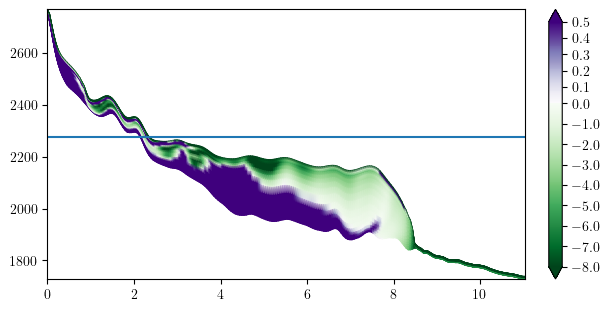

In [160]:
fig, ax, cbar = enthalpy_pcolormesh(src, -1)

ax.axhline(2275)
